In [141]:
importlib.reload(rank)

<module 'pipeline.rank' from '/Users/danielfriedman/Desktop/hoops/pipeline/rank.py'>

In [142]:
games = team_metadata.get_game_by_game("2021-22")

In [144]:
games.iloc[:200]

,game_id,date,home,vis,home_score,vis_score,home_win
0,22100001,2021-10-19,MIL,BKN,127,104,True
1,22100002,2021-10-19,LAL,GSW,114,121,False
2,22100003,2021-10-20,CHA,IND,123,122,True
3,22100004,2021-10-20,DET,CHI,88,94,False
4,22100005,2021-10-20,NYK,BOS,138,134,True
...,...,...,...,...,...,...,...
195,22100196,2021-11-14,OKC,BKN,96,120,False
196,22100197,2021-11-14,DEN,POR,124,95,True
197,22100198,2021-11-14,LAC,CHI,90,100,False
198,22100199,2021-11-15,CLE,BOS,92,98,False


In [174]:
importlib.reload(rank)
rankings = rank.get_rankings(games=games, shrinkage=1.5)
rankings_100 = rank.get_rankings(games=games.iloc[:100], shrinkage=1.5)

<AxesSubplot:>

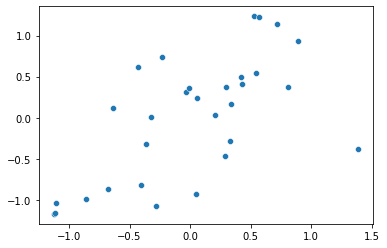

In [183]:
sns.scatterplot(x=pd.Series(rankings).sort_index(), y=pd.Series(rankings_100).sort_index())

In [185]:
games.iloc[:100].loc[

,game_id,date,home,vis,home_score,vis_score,home_win
0,22100001,2021-10-19,MIL,BKN,127,104,True
1,22100002,2021-10-19,LAL,GSW,114,121,False
2,22100003,2021-10-20,CHA,IND,123,122,True
3,22100004,2021-10-20,DET,CHI,88,94,False
4,22100005,2021-10-20,NYK,BOS,138,134,True
...,...,...,...,...,...,...,...
95,22100096,2021-11-01,PHI,POR,113,103,True
96,22100097,2021-11-01,ATL,WAS,118,111,True
97,22100098,2021-11-01,BOS,CHI,114,128,False
98,22100099,2021-11-01,NYK,TOR,104,113,False


In [184]:
pd.Series(rankings_100)

HOU   -1.169143
ORL   -1.159641
NOP   -1.073359
DET   -1.033075
OKC   -0.983149
         ...   
WAS    0.742743
GSW    0.929849
MIA    1.135489
UTA    1.221576
CHI    1.234326
Length: 30, dtype: float64

In [177]:
pd.Series(rankings)

HOU   -1.125351
ORL   -1.112548
DET   -1.103330
OKC   -0.856831
IND   -0.674404
         ...   
UTA    0.572207
MIA    0.714830
MEM    0.812017
GSW    0.894477
PHX    1.387110
Length: 30, dtype: float64

In [119]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 25)

from pipeline import team_metadata, score_by_score, rank

In [23]:
seasons = [f"20{year}-{year+1}" for year in range(17, 22)]


#### Get Records by Date

In [24]:
## Get records by date
importlib.reload(team_metadata)
rbd = team_metadata.get_records_by_date(seasons)
rbd.tail()


,date,game_id,home,vis,home_house_wins,home_house_losses,home_road_wins,home_road_losses,vis_house_wins,vis_house_losses,vis_road_wins,vis_road_losses,home_house_games,home_road_games,home_house_win_pct,home_road_win_pct,vis_house_games,vis_road_games,vis_house_win_pct,vis_road_win_pct
5515,2022-02-28,22100921,ORL,IND,6,21,8,26,15,18,6,23,27,34,0.222222,0.235294,33,29,0.454545,0.206897
5516,2022-02-28,22100922,MIA,CHI,20,7,20,14,24,9,15,13,27,34,0.740741,0.588235,33,28,0.727273,0.535714
5517,2022-02-28,22100923,MEM,SAS,20,10,22,10,11,18,13,19,30,32,0.666667,0.6875,29,32,0.37931,0.40625
5518,2022-02-28,22100924,MIL,CHA,20,12,16,13,16,14,15,17,32,29,0.625,0.551724,30,32,0.533333,0.46875
5519,2022-02-28,22100925,OKC,SAC,9,20,10,21,15,18,7,22,29,31,0.310345,0.322581,33,29,0.454545,0.241379


#### Get Rankings by Date

In [ ]:
season = "2021-22"
season_rbd = pd.read_csv(data_dir / "rankings" / (season + ".csv"))
season_rbd

,team,ranking,date
0,LAL,-0.663424,2021-10-20
1,BKN,-0.546865,2021-10-20
2,MIL,0.546865,2021-10-20
3,GSW,0.663423,2021-10-20
4,LAL,-0.663424,2021-10-21
...,...,...,...
145,UTA,1.046336,2021-10-25
146,DEN,1.051827,2021-10-25
147,CHI,1.100795,2021-10-25
148,GSW,1.319985,2021-10-25


#### Get Score by Score

In [25]:
## Get score by score
importlib.reload(score_by_score)
sbs = score_by_score.get_sbs(seasons)
sbs.tail()

,game_id,home,vis,time,home_score,vis_score,home_win
6,22100629,NOP,LAC,46.38,106,86,True
7,22100629,NOP,LAC,46.65,108,86,True
8,22100629,NOP,LAC,46.75,110,86,True
9,22100629,NOP,LAC,47.28,113,86,True
10,22100629,NOP,LAC,47.40,113,89,True


#### Merge

In [26]:
## Merge!
rbd_ = rbd.copy(deep=True)
rbd_['home_wins'] = rbd_['home_house_wins'] + rbd_['home_road_wins']
rbd_['home_losses'] = rbd_['home_house_losses'] + rbd_['home_road_losses']
rbd_['home_games'] = rbd_['home_wins'] + rbd_['home_losses']
rbd_['home_win_pct'] = rbd_['home_wins'] / (rbd_['home_wins'] + rbd_['home_losses']).replace(0, -1)
rbd_['vis_wins'] = rbd_['vis_house_wins'] + rbd_['vis_road_wins']
rbd_['vis_losses'] = rbd_['vis_house_losses'] + rbd_['vis_road_losses']
rbd_['vis_games'] = rbd_['vis_wins'] + rbd_['vis_losses']
rbd_['vis_win_pct'] = rbd_['vis_wins'] / (rbd_['vis_wins'] + rbd_['vis_losses']).replace(0, -1)
rbd_ = rbd_[['game_id', 'home', 'vis', 'home_win_pct', 'vis_win_pct', 'home_games', 'vis_games']]
m = pd.merge(left=sbs, right=rbd_, on=['game_id', 'home', 'vis'])
m['home_lead'] = m['home_score'] - m['vis_score']
# m['home_win_margin'] = m['home_wins'] - m['home_losses']
# m['vis_win_margin'] = m['vis_wins'] - m['vis_losses']
m = m.loc[(m['home_games'] >= 5) & (m['vis_games'] >=5)]
m.tail()


,game_id,home,vis,time,home_score,vis_score,home_win,home_win_pct,vis_win_pct,home_games,vis_games,home_lead
643109,22100629,NOP,LAC,46.38,106,86,True,0.365854,0.5,41,42,20
643110,22100629,NOP,LAC,46.65,108,86,True,0.365854,0.5,41,42,22
643111,22100629,NOP,LAC,46.75,110,86,True,0.365854,0.5,41,42,24
643112,22100629,NOP,LAC,47.28,113,86,True,0.365854,0.5,41,42,27
643113,22100629,NOP,LAC,47.40,113,89,True,0.365854,0.5,41,42,24


#### Empirical Means

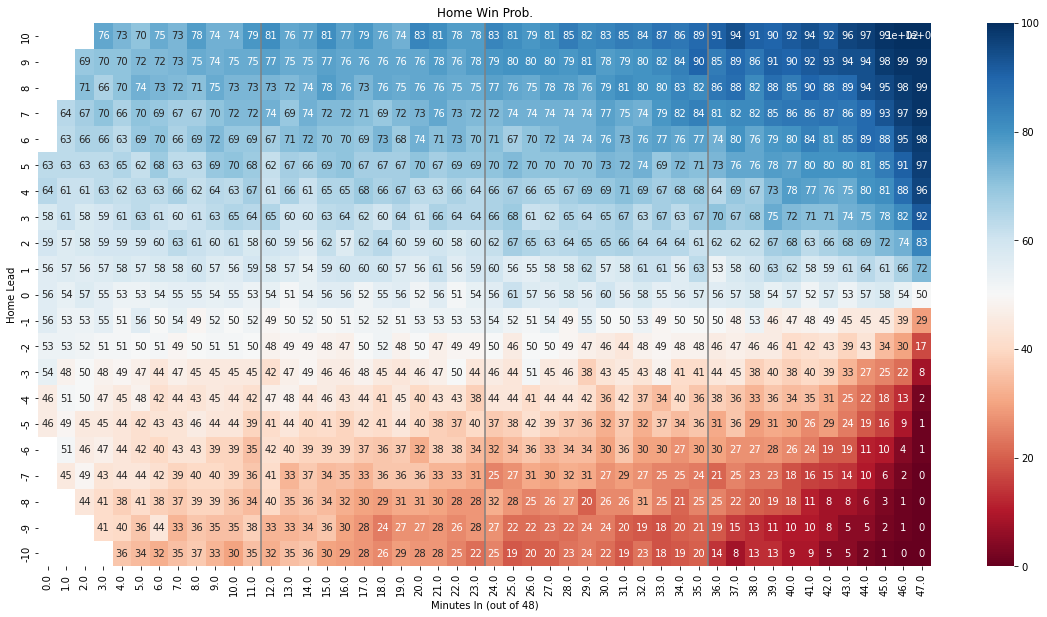

In [27]:
time_mod = 1
score_mod = 1
sbs['mins'] = sbs['time'] // time_mod
sbs['home_lead'] = (sbs['home_score'] - sbs['vis_score']) // score_mod

x = sbs.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 100]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



# XGB

In [29]:
mod = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)
params = {
    'n_estimators': [50],
    'eta': [.1],
    'max_depth': [4],
    'min_child_weight': [50],
    'lambda': [1]
}
X = m[['home_win_pct', 'vis_win_pct', 'home_lead', 'mins']].to_numpy()
y = m['home_win'].astype(int).to_numpy()
grid_search = GridSearchCV(mod, params, scoring="neg_log_loss", n_jobs=-1, cv=5)
grid_result = grid_search.fit(X, y)
best_params = grid_search.best_params_ # {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50}
mod = grid_search.best_estimator_
best_params


{'eta': 0.1,
 'lambda': 1,
 'max_depth': 4,
 'min_child_weight': 50,
 'n_estimators': 50}

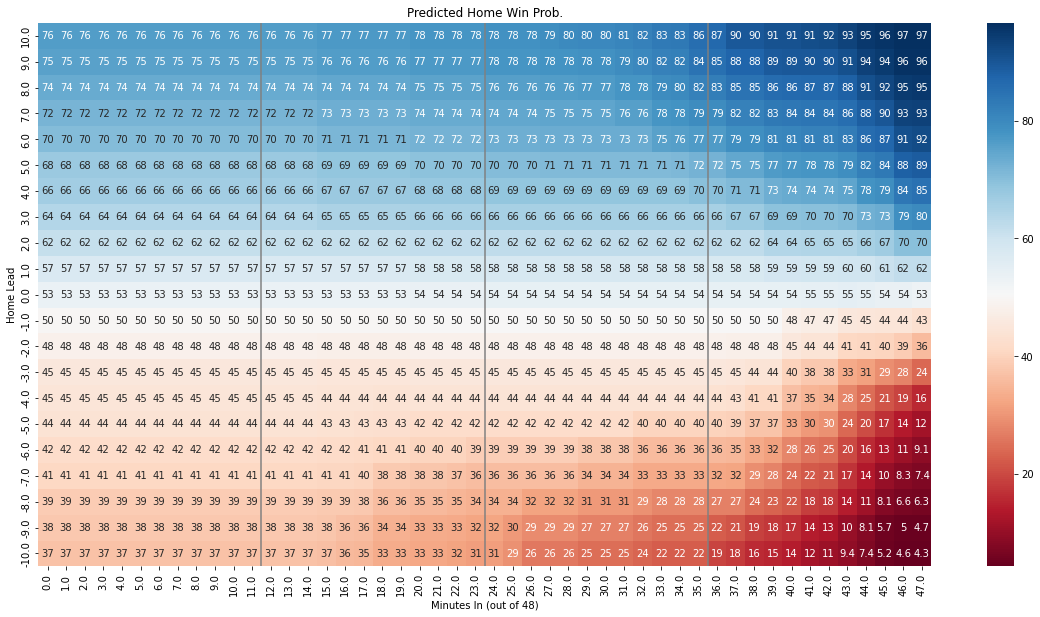

In [30]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        [.5]*len(mins)*len(home_leads),
        [.5]*len(mins)*len(home_leads),
        np.repeat(home_leads, len(mins)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



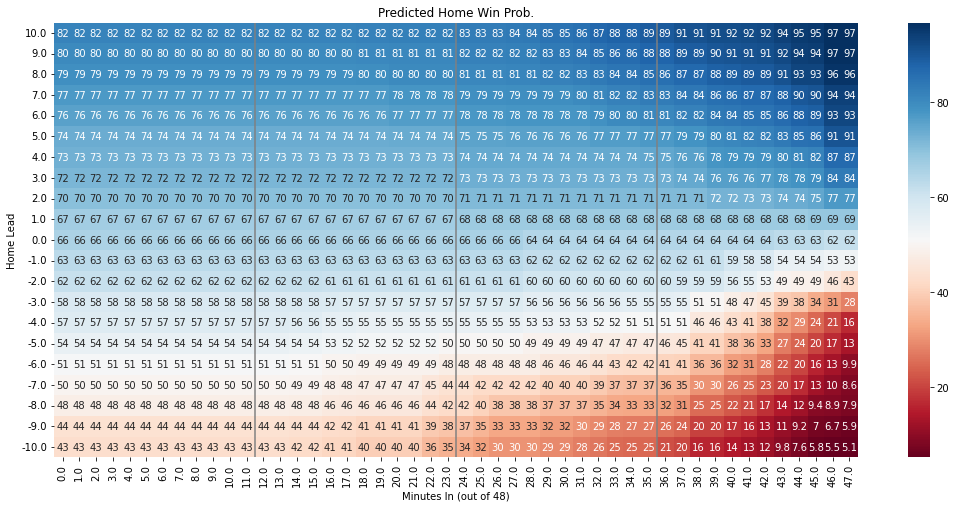

In [45]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        [.65]*len(mins)*len(home_leads),
        [.5]*len(mins)*len(home_leads),
        np.repeat(home_leads, len(mins)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(18, 8))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



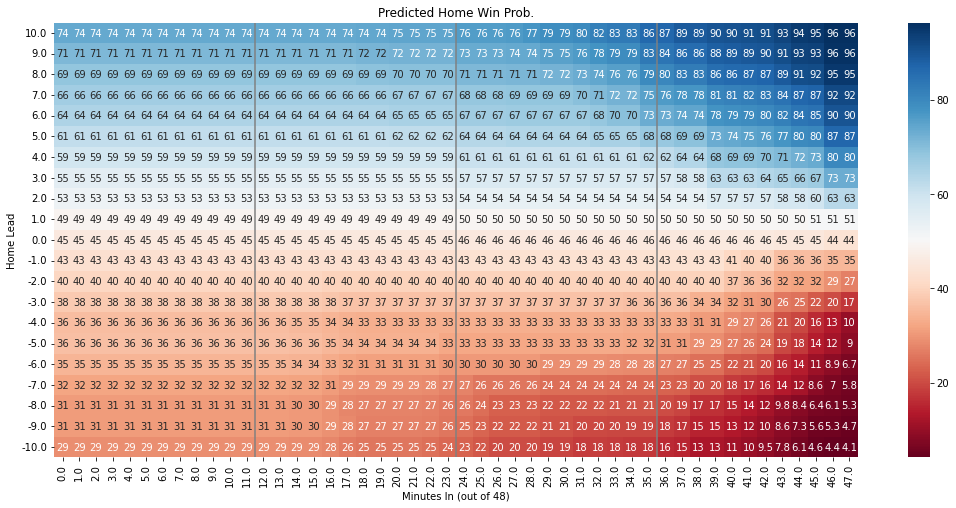

In [46]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        [.5]*len(mins)*len(home_leads),
        [.65]*len(mins)*len(home_leads),
        np.repeat(home_leads, len(mins)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(18, 8))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



# Feature Eng

In [31]:
m.head()

,game_id,home,vis,time,home_score,vis_score,home_win,home_win_pct,vis_win_pct,home_games,vis_games,home_lead,mins
0,21700891,SAC,LAL,0.00,0,0,False,0.310345,0.413793,58,58,0,0.0
1,21700891,SAC,LAL,0.30,0,2,False,0.310345,0.413793,58,58,-2,0.0
2,21700891,SAC,LAL,0.95,2,2,False,0.310345,0.413793,58,58,0,0.0
3,21700891,SAC,LAL,1.45,5,2,False,0.310345,0.413793,58,58,3,1.0
4,21700891,SAC,LAL,1.90,5,5,False,0.310345,0.413793,58,58,0,1.0


In [32]:
## Trend
trend_size = 10
m['home_trend'] = m['home_lead'] - m['home_lead'].shift(trend_size)
game_id_trend_ago = m['game_id'].shift(trend_size)
m.loc[m['game_id'] != game_id_trend_ago, 'home_trend'] = np.nan

In [33]:
## Scoring Rate
m['total_points'] = m['home_score'] + m['vis_score']
m['ppm'] = m['total_points'] / m['time']


In [34]:
mod = XGBClassifier(
    ## Objective/Eval
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    
    ## Fitting Params
    n_estimators=300,
    eta=.01,
    max_depth=5,
    reg_lambda=10,
    reg_alpha=0,
    gamma=3,
    min_child_weight=3,
    colsample_bytree=0.9
)

# X = m[['home_win_pct', 'vis_win_pct', 'home_lead', 'mins']].to_numpy()
X = m[['home_win_pct', 'vis_win_pct', 'home_lead', 'ppm', 'total_points', 'mins']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=124)
mod.fit(X_train, y_train)
y_hat = mod.predict_proba(X_test)[:,1]
mod.score(X_test, y_test)


0.7724786820840216

0.03839277144769967


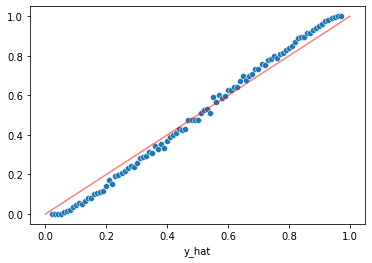

In [35]:
modulo = .01
ys = pd.DataFrame({'y':y_test, 'y_hat':y_hat}).sort_values(['y', 'y_hat'])
ybar_by_yhat = ys.groupby(ys['y_hat'] // modulo)['y'].mean()
ybar_by_yhat.index *= modulo

print(np.mean(abs(ybar_by_yhat - ybar_by_yhat.index)))
sns.scatterplot(x=ybar_by_yhat.index, y=ybar_by_yhat.values)
sns.lineplot(x=np.arange(2), y=np.arange(2), color='red', alpha=0.5);


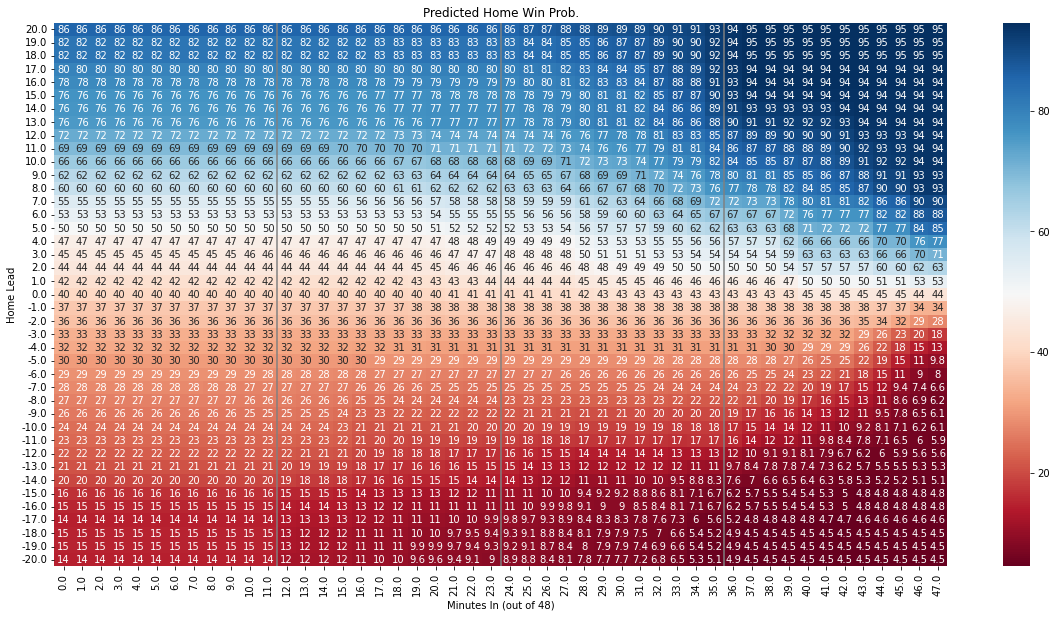

In [36]:
mins = np.arange(0, 48)
home_leads = np.arange(-20, 21)
dummy_data = pd.DataFrame(
    np.array([
        np.tile(.36, len(mins)*len(home_leads)),
        np.tile(.57, len(mins)*len(home_leads)),
        np.repeat(home_leads, len(mins)),
        np.tile(5, len(mins)*len(home_leads)),
        np.tile(5*mins, len(home_leads)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'ppm', 'total_points', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(20, 10))
annot=False
annot=True
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel.loc[::-1, :]*100, annot=annot, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



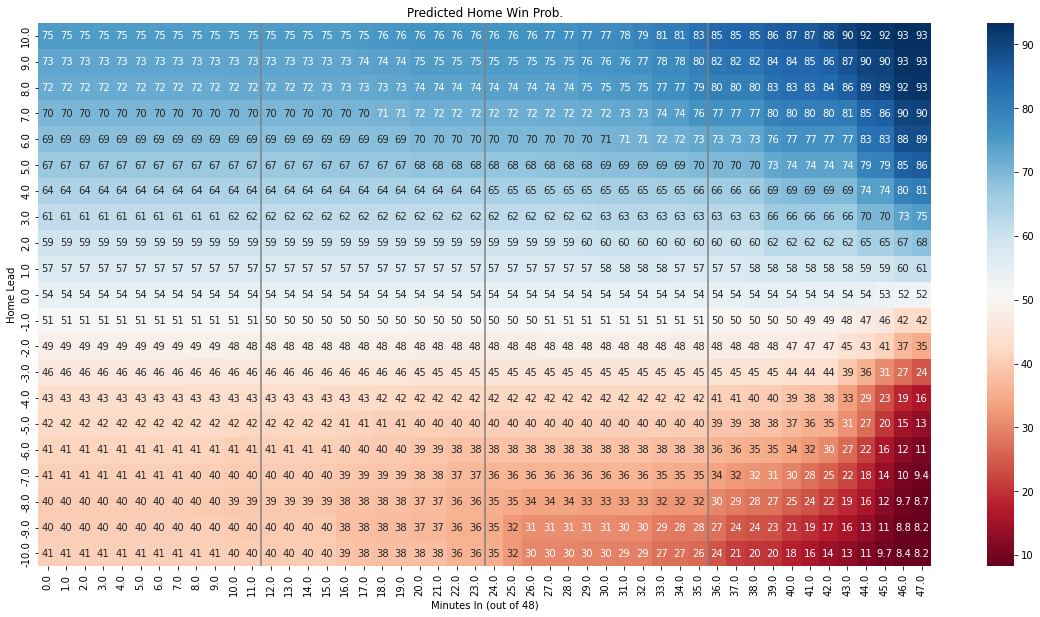

In [40]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        np.tile(.5, len(mins)*len(home_leads)),
        np.tile(.5, len(mins)*len(home_leads)),
        np.repeat(home_leads, len(mins)),
        np.tile(3.5, len(mins)*len(home_leads)),
        np.tile(3.5*mins, len(home_leads)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'ppm', 'total_points', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel_ = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
annot = True
sns.heatmap(panel_.loc[::-1, :]*100, annot=annot, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



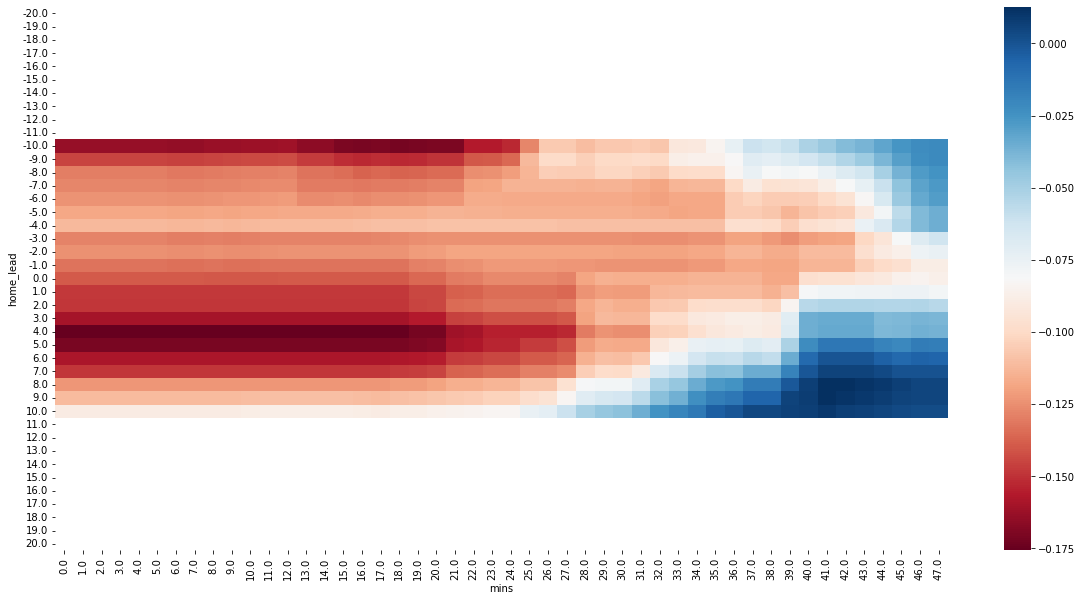

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
# sns.heatmap(panel - panel_, cmap="RdBu", vmin=-.05, vmax=.05);
sns.heatmap(panel - panel_, cmap="RdBu");
